In [ ]:
from pathlib import Path
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Global configuration
DATASET_DIR = Path("dataset_yolo")  # folder that contains train/, val/, test/, neu_det.yaml

CLASS_NAMES = [
    "crazing",
    "inclusion",
    "patches",
    "pitted_surface",
    "rolled-in_scale",
    "scratches",
]

# Random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [3]:
# Function to load YOLO labels
def load_yolo_labels(label_path: Path):
    """
    Read a YOLO label file and return a list of boxes:
    each box is a dict with keys: class_id, xc, yc, w, h.
    """
    boxes = []
    if not label_path.exists():
        return boxes

    with label_path.open("r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id = int(parts[0])
            xc = float(parts[1])
            yc = float(parts[2])
            w = float(parts[3])
            h = float(parts[4])
            boxes.append(
                {"class_id": class_id, "xc": xc, "yc": yc, "w": w, "h": h}
            )
    return boxes

# Function to denormalize YOLO box coordinates, converting them to pixel coordinates
def denormalize_box(box, img_w, img_h):
    """
    Convert normalized YOLO box -> pixel coords (xmin, ymin, xmax, ymax).
    """
    xc = box["xc"] * img_w
    yc = box["yc"] * img_h
    bw = box["w"] * img_w
    bh = box["h"] * img_h

    xmin = int(xc - bw / 2)
    ymin = int(yc - bh / 2)
    xmax = int(xc + bw / 2)
    ymax = int(yc + bh / 2)

    # clamp to image bounds
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(img_w - 1, xmax)
    ymax = min(img_h - 1, ymax)

    return xmin, ymin, xmax, ymax

# Function to visualize random training images with bounding boxes
def visualize_random_train_images(num_images=10, cols=5):
    """
    Randomly select num_images from train/images and plot them
    with their bounding boxes and labels.
    """
    train_img_dir = DATASET_DIR / "train" / "images"
    train_lbl_dir = DATASET_DIR / "train" / "labels"

    img_files = sorted(
        [f for f in train_img_dir.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]]
    )

    if not img_files:
        raise RuntimeError(f"No images found in {train_img_dir}")

    selected = random.sample(img_files, min(num_images, len(img_files)))

    rows = (len(selected) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1)  # flatten in case of 1 row

    for ax, img_path in zip(axes, selected):
        img = cv2.imread(str(img_path))
        if img is None:
            ax.set_title(f"Cannot read {img_path.name}")
            ax.axis("off")
            continue

        img_h, img_w = img.shape[:2]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label_path = train_lbl_dir / (img_path.stem + ".txt")
        boxes = load_yolo_labels(label_path)

        # draw boxes
        for box in boxes:
            xmin, ymin, xmax, ymax = denormalize_box(box, img_w, img_h)
            class_id = box["class_id"]
            class_name = CLASS_NAMES[class_id] if 0 <= class_id < len(CLASS_NAMES) else str(class_id)

            cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(
                img_rgb,
                class_name,
                (xmin, max(0, ymin - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.3,
                (255, 0, 0),
                1,
                cv2.LINE_AA,
            )

        ax.imshow(img_rgb)
        ax.set_title(img_path.name)
        ax.axis("off")

    # hide any unused axes
    for i in range(len(selected), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

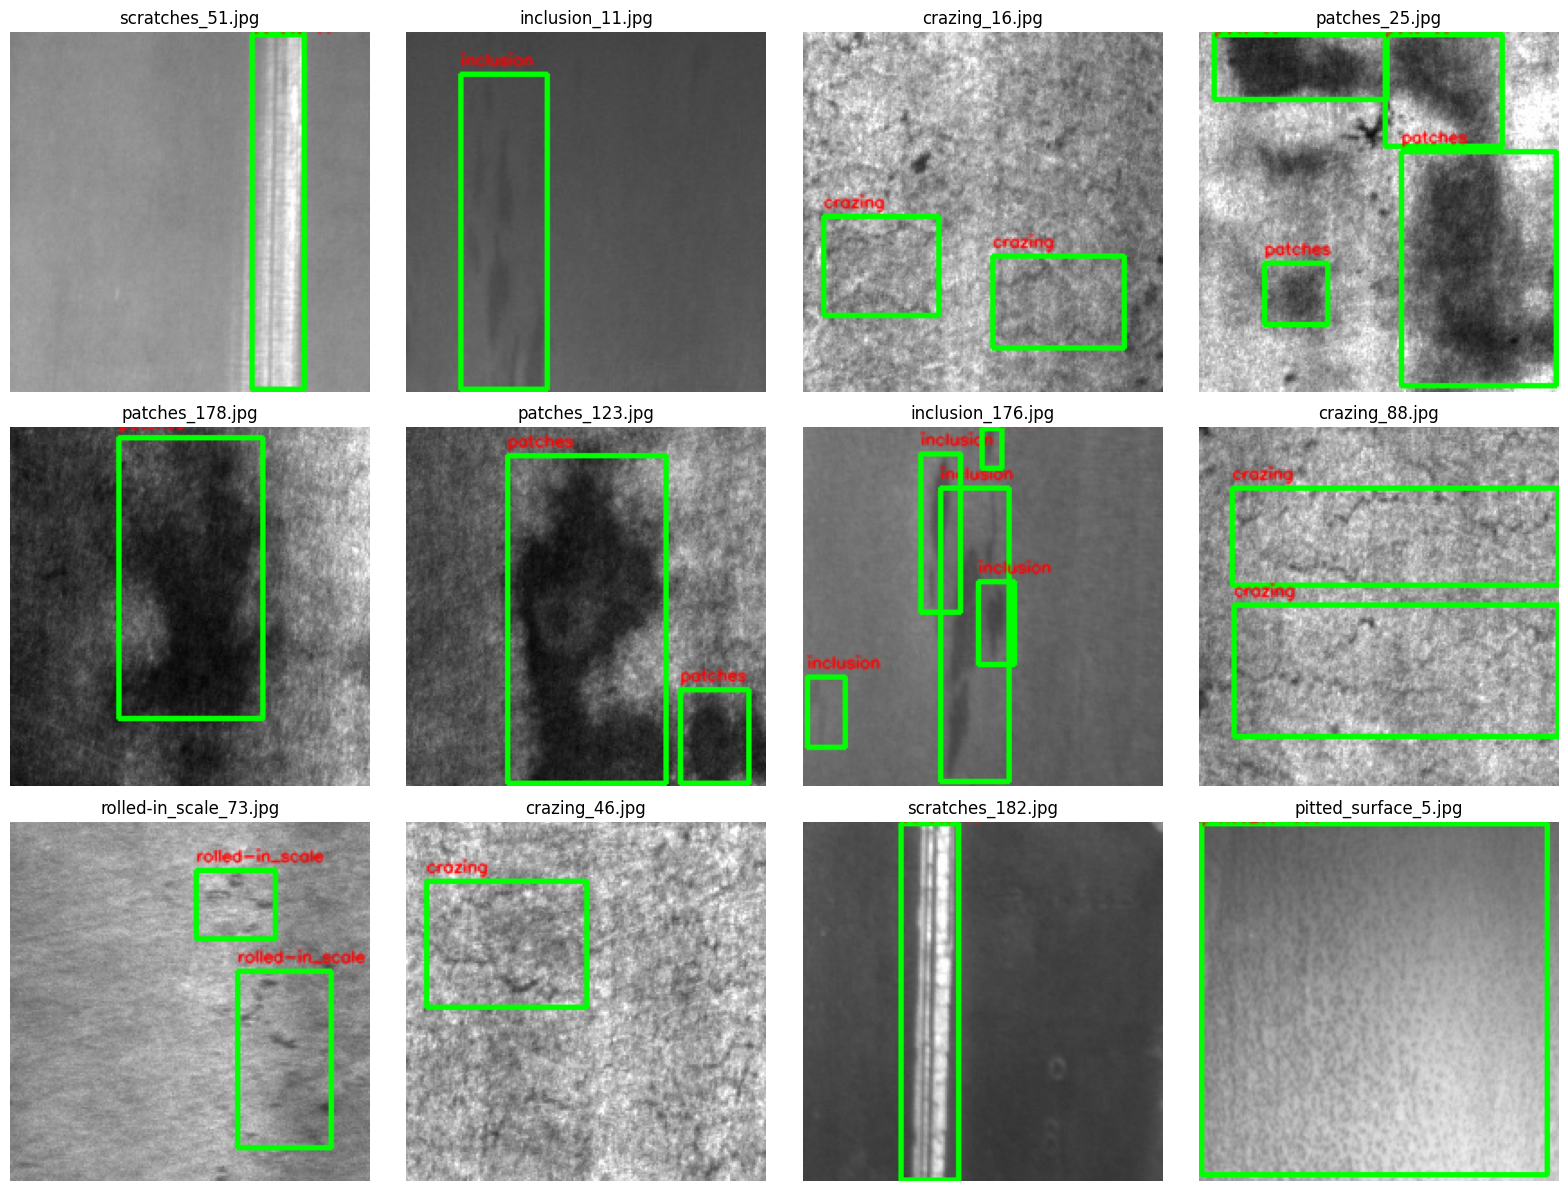

In [4]:
# Visualize random training images with bounding boxes
visualize_random_train_images(num_images=12, cols=4)